In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline

# 0. Load data into pandas dataframe

In [3]:
sf_scooter = pd.read_excel('Analyst Exercise Trip Data.xlsx')

In [4]:
sf_scooter.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Scooter #,Subscriber Type,Zip Code
0,198776,177,2018-01-03 00:14:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2018-01-03 00:17:00,Market at Sansome,77,398,Subscriber,94105
1,198777,445,2018-01-03 00:16:00,San Francisco Caltrain (Townsend at 4th),70,2018-01-03 00:23:00,Embarcadero at Bryant,54,268,Subscriber,94105
2,198778,224,2018-01-03 00:21:00,Civic Center BART (7th at Market),72,2018-01-03 00:25:00,Golden Gate at Polk,59,380,Subscriber,94103
3,198779,179,2018-01-03 00:22:00,Powell Street BART,39,2018-01-03 00:25:00,Market at 4th,76,439,Subscriber,94107
4,198780,429,2018-01-03 00:42:00,Spear at Folsom,49,2018-01-03 00:49:00,Broadway St at Battery St,82,395,Subscriber,94105


# 1. The distribution of usage duration of scooter
## 1.1 Group the duration into hours and minutes

In [5]:
sf_scooter['Duration_minutes'] = (sf_scooter['Duration']/60).astype('int64')
sf_scooter['Duration_hours'] = (sf_scooter['Duration']/3600).astype('int64')

## 1.2 plot the distribution in terms of hours
We can see most of the trips will ends with in one hour, while there are some outliers stand at 100 hours or 200 hours. That may be due to the users forgot to return the scooters or some other issues. However, we will focus on the samples located around 1 hour to see what does the distribution look like there.

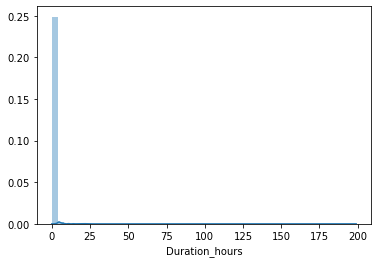

In [6]:
sns.distplot(sf_scooter['Duration_hours'])

This distribution further confirms our understanding that most of the trips are within 1 hour.

# 1.3 Plot the distribution in terms of minutes

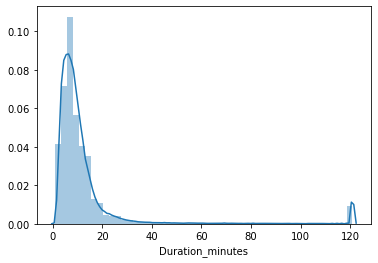

In [7]:
sns.distplot(sf_scooter['Duration_minutes'].where(sf_scooter['Duration_minutes'] < 120, 121))

From the distribution plot, we can see the median of the duration is at 8 minute while the mean goes to 18 minutes, which is quite far from the median. That may indicate that there is a long tail in the distribution of the usage duration, which might suffers the number of total available scooters.

In [8]:
sf_scooter['Duration_minutes'].describe()

count    171792.000000
mean         18.384151
std         101.404901
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max       11941.000000
Name: Duration_minutes, dtype: float64

In [9]:
sf_scooter['Duration_minutes'].median()

8.0

However, most of trips are very efficent, as we can see, 95.5% of trips will be able to finish in 40 minutes. 

In [10]:
print(float(len(sf_scooter[sf_scooter['Duration_minutes']<=40]))/float(len(sf_scooter)))

0.9547650647294402


## 2. The hot routes during peak hours 

## 2.1 Analysing peak hours

In [11]:
sf_scooter['Start Date'] = sf_scooter['Start Date'].apply(lambda x: pd.to_datetime(x))
sf_scooter['End Date'] = sf_scooter['End Date'].apply(lambda x: pd.to_datetime(x))
sf_scooter['Start Hour'] = sf_scooter['Start Date'].dt.hour.astype('int64')
sf_scooter['End Hour'] = sf_scooter['End Date'].dt.hour.astype('int64')

In [12]:
sf_scooter["Week Day"] = sf_scooter["Start Date"].dt.strftime("%d").astype("int64") % 7
sf_scooter.loc[sf_scooter["Week Day"] == 0, "Week Day"] = 7

In [13]:
sf_scooter

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Scooter #,Subscriber Type,Zip Code,Duration_minutes,Duration_hours,Start Hour,End Hour,Week Day
0,198776,177,2018-01-03 00:14:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2018-01-03 00:17:00,Market at Sansome,77,398,Subscriber,94105,2,0,0,0,3
1,198777,445,2018-01-03 00:16:00,San Francisco Caltrain (Townsend at 4th),70,2018-01-03 00:23:00,Embarcadero at Bryant,54,268,Subscriber,94105,7,0,0,0,3
2,198778,224,2018-01-03 00:21:00,Civic Center BART (7th at Market),72,2018-01-03 00:25:00,Golden Gate at Polk,59,380,Subscriber,94103,3,0,0,0,3
3,198779,179,2018-01-03 00:22:00,Powell Street BART,39,2018-01-03 00:25:00,Market at 4th,76,439,Subscriber,94107,2,0,0,0,3
4,198780,429,2018-01-03 00:42:00,Spear at Folsom,49,2018-01-03 00:49:00,Broadway St at Battery St,82,395,Subscriber,94105,7,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171787,432941,1091,2018-08-31 21:44:00,Embarcadero at Sansome,60,2018-08-31 22:02:00,Steuart at Market,74,598,Customer,94521,18,0,21,22,3
171788,432942,1041,2018-08-31 21:45:00,Embarcadero at Sansome,60,2018-08-31 22:02:00,Steuart at Market,74,603,Customer,94521,17,0,21,22,3
171789,432944,534,2018-08-31 22:06:00,Beale at Market,56,2018-08-31 22:15:00,Market at 4th,76,342,Customer,11231,8,0,22,22,3
171790,432945,468,2018-08-31 22:07:00,Beale at Market,56,2018-08-31 22:15:00,Market at 4th,76,509,Customer,11231,7,0,22,22,3


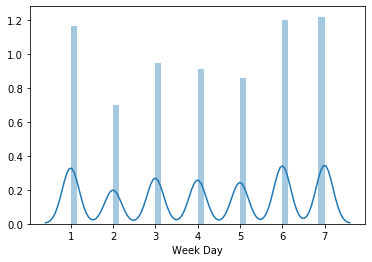

In [15]:
sns.distplot(sf_scooter["Week Day"])

It is interesting that the trips on weekend is instead higher than that on weekdays. Next, we dig deeper to see which station accounts for the most number of trips. 

From the graph, we can see that the peak hour in terms of start time would be 7, 8, 9 am and 16, 17, 18 pm. That may be caused by the commuting transportation when people go to work and go off work everyday. 

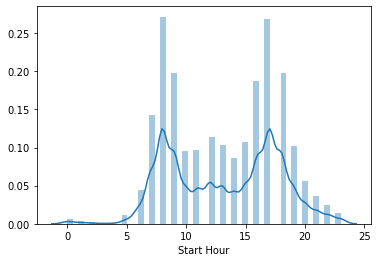

In [13]:
sns.distplot(sf_scooter['Start Hour'])

## 2.2 The hot routes in morning rush hours

### 2.2.1 Start Stations

In [14]:
morning = sf_scooter[sf_scooter['Start Hour'].isin((7,8,9))]

In [15]:
morning.head()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Scooter #,Subscriber Type,Zip Code,Duration_minutes,Duration_hours,Start Hour,End Hour
18,198809,395,2018-01-03 07:57:00,Grant Avenue at Columbus Avenue,73,2018-01-03 08:03:00,Market at Sansome,77,311,Subscriber,94133,6,0,7,8
19,198813,297,2018-01-03 08:18:00,Embarcadero at Bryant,54,2018-01-03 08:23:00,Steuart at Market,74,327,Subscriber,94105,4,0,8,8
20,198814,432,2018-01-03 08:29:00,Commercial at Montgomery,45,2018-01-03 08:36:00,Powell Street BART,39,437,Subscriber,94111,7,0,8,8
21,198815,643,2018-01-03 08:32:00,Embarcadero at Bryant,54,2018-01-03 08:42:00,Embarcadero at Sansome,60,409,Subscriber,94105,10,0,8,8
22,198816,368,2018-01-03 08:35:00,South Van Ness at Market,66,2018-01-03 08:42:00,Powell Street BART,39,483,Subscriber,94404,6,0,8,8


Group by the start station and count the distinct number of trip ids for each start station.
From the table below, we can see 14.7% of passengers start form terminal, which is 2 times higher than the terminal ranked at the second place. Hence there is a significant gap between terminal 70 and the other terminals. 

In [16]:
df_start_station = morning.groupby('Start Station').agg({'Start Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
df_start_station['Percentage'] = df_start_station['Trip ID']/sum(df_start_station['Trip ID'])
df_start_station

,Start Terminal,Trip ID,Percentage
Start Station,,,
San Francisco Caltrain (Townsend at 4th),70,7101,0.146812
San Francisco Caltrain 2 (330 Townsend),69,3518,0.072734
Temporary Transbay Terminal (Howard at Beale),55,3346,0.069178
Harry Bridges Plaza (Ferry Building),50,3134,0.064795
Steuart at Market,74,2243,0.046374
...,...,...,...
Adobe on Almaden,5,10,0.000207
Santa Clara County Civic Center,80,7,0.000145
San Mateo County Center,23,3,0.000062


From the 

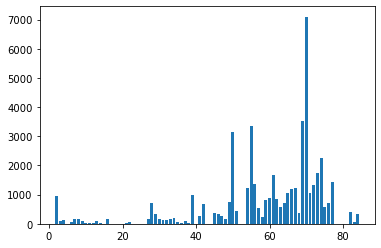

In [17]:
plt.bar(df_start_station['Start Terminal'], df_start_station['Trip ID'], align='center')#, alpha=0.5)
plt.show()

### 2.2.1 End Stations

For the end stations, terminal 70 is still the top one place, while the whole sample is more evenly distributed. Combined with the previous discussion, these two tables imply that there is a large amount of people start from terminal 70 and head to different places in every morning. 

In [18]:
df_end_station = morning.groupby('End Station').agg({'End Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
df_end_station['Percentage'] = df_end_station['Trip ID']/sum(df_end_station['Trip ID'])
df_end_station

,End Terminal,Trip ID,Percentage
End Station,,,
San Francisco Caltrain (Townsend at 4th),70,3655,0.075566
2nd at Townsend,61,2810,0.058096
Market at Sansome,77,2636,0.054499
Townsend at 7th,65,2321,0.047986
Embarcadero at Sansome,60,1851,0.038269
...,...,...,...
SJSU - San Salvador at 9th,16,17,0.000351
San Salvador at 1st,8,13,0.000269
Redwood City Public Library,24,7,0.000145


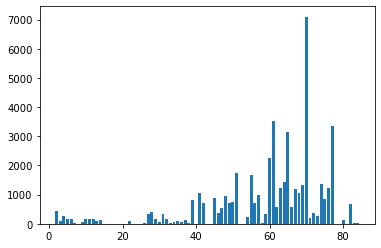

In [19]:
plt.bar(df_end_station['End Terminal'], df_start_station['Trip ID'], align='center')
plt.show()

Further explaination and visualization goes to the tableau file. 

## The heatmap of demand and supply of the scooters in different stations.

such that people can know which place needs more scooters and which does not.

In [20]:
import seaborn as sns

In [21]:
morning

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Scooter #,Subscriber Type,Zip Code,Duration_minutes,Duration_hours,Start Hour,End Hour
18,198809,395,2018-01-03 07:57:00,Grant Avenue at Columbus Avenue,73,2018-01-03 08:03:00,Market at Sansome,77,311,Subscriber,94133,6,0,7,8
19,198813,297,2018-01-03 08:18:00,Embarcadero at Bryant,54,2018-01-03 08:23:00,Steuart at Market,74,327,Subscriber,94105,4,0,8,8
20,198814,432,2018-01-03 08:29:00,Commercial at Montgomery,45,2018-01-03 08:36:00,Powell Street BART,39,437,Subscriber,94111,7,0,8,8
21,198815,643,2018-01-03 08:32:00,Embarcadero at Bryant,54,2018-01-03 08:42:00,Embarcadero at Sansome,60,409,Subscriber,94105,10,0,8,8
22,198816,368,2018-01-03 08:35:00,South Van Ness at Market,66,2018-01-03 08:42:00,Powell Street BART,39,483,Subscriber,94404,6,0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171374,432386,329,2018-08-31 09:57:00,Mechanics Plaza (Market at Battery),75,2018-08-31 10:02:00,Harry Bridges Plaza (Ferry Building),50,434,Customer,84106,5,0,9,10
171375,432387,323,2018-08-31 09:57:00,Mechanics Plaza (Market at Battery),75,2018-08-31 10:03:00,Harry Bridges Plaza (Ferry Building),50,525,Customer,87123,5,0,9,10
171376,432388,542,2018-08-31 09:59:00,Powell Street BART,39,2018-08-31 10:08:00,Townsend at 7th,65,280,Customer,80797,9,0,9,10
171377,432389,1025,2018-08-31 09:59:00,San Francisco City Hall,58,2018-08-31 10:16:00,Beale at Market,56,342,Customer,22213,17,0,9,10


In [22]:
start_station = morning.groupby(['Start Station', 'Start Terminal']).agg(start_trips=('Trip ID', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"Start Station": "Station", "Start Terminal": "Terminal"})

end_station = morning.groupby(['End Station', 'End Terminal']).agg(end_trips=('Trip ID', pd.Series.nunique)) \
.reset_index() \
.rename(columns={"End Station": "Station", "End Terminal": "Terminal"})

In [23]:
start_end = start_station.merge(end_station, on=("Station", "Terminal"))[["Station", "start_trips", "end_trips"]].set_index("Station")

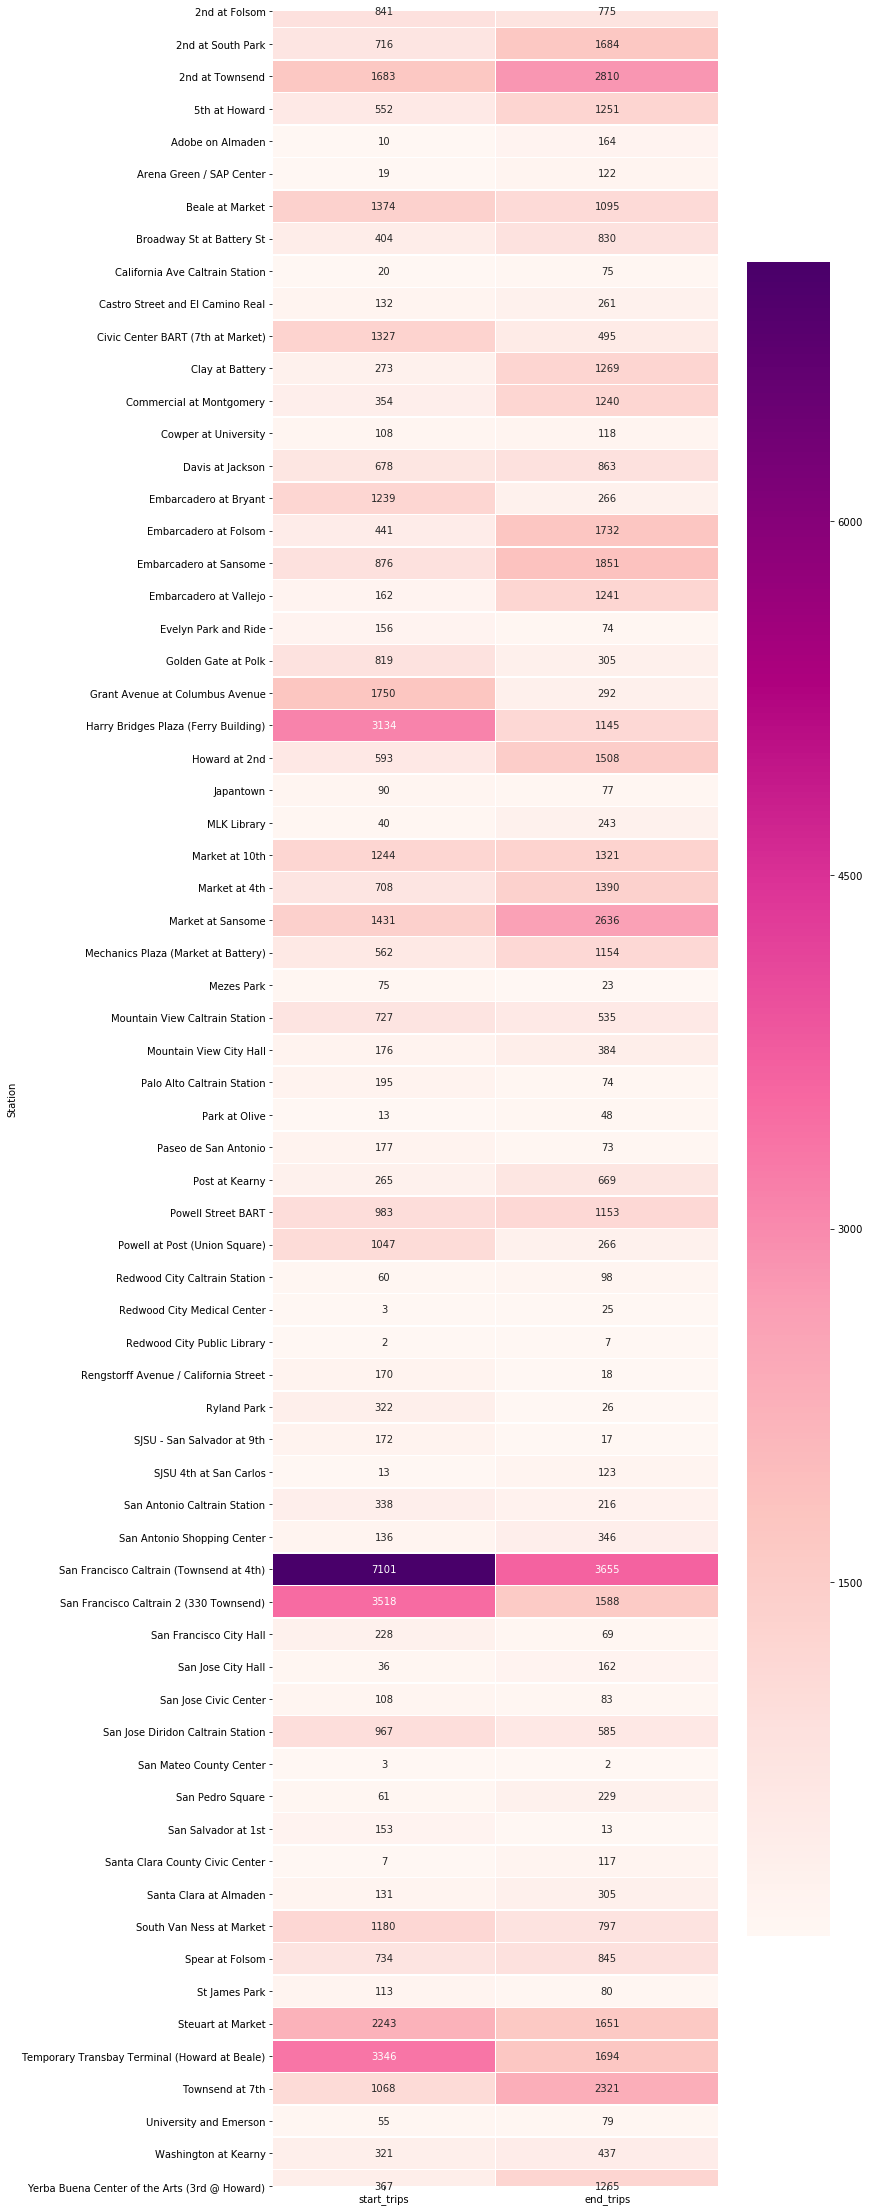

In [27]:
fig, ax = plt.subplots(figsize=(10,40))
sns.heatmap(start_end, ax=ax, annot=True, fmt="d", linewidths=.5, cmap="RdPu")

In [41]:
start_end[(start_end["start_trips"] > start_end["end_trips"] * 1.2) 
          & (start_end["start_trips"] > start_end["end_trips"] + 50)]

,start_trips,end_trips
Station,,
Beale at Market,1374,1095
Civic Center BART (7th at Market),1327,495
Embarcadero at Bryant,1239,266
Evelyn Park and Ride,156,74
Golden Gate at Polk,819,305
Grant Avenue at Columbus Avenue,1750,292
Harry Bridges Plaza (Ferry Building),3134,1145
Mezes Park,75,23
Mountain View Caltrain Station,727,535


More scooters could be allocated to these stations. 

## 2.3 The hot routes in afternoon rush hours

### 2.3.1 Start Stations

In [67]:
afternoon = sf_scooter[sf_scooter['Start Hour'].isin((16,17,18))]

In contrast, the starting stations in the afternoon are very evenly distributed. People may go off work from different work places at that time.

In [66]:
a_df_start_station = afternoon.groupby('Start Station').agg({'Start Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
a_df_start_station['Percentage'] = a_df_start_station['Trip ID']/sum(a_df_start_station['Trip ID'])
a_df_start_station

,Start Terminal,Trip ID,Percentage
Start Station,,,
Embarcadero at Sansome,60,2666,0.050621
2nd at Townsend,61,2483,0.047146
Market at Sansome,77,2342,0.044469
San Francisco Caltrain (Townsend at 4th),70,2278,0.043254
Townsend at 7th,65,2165,0.041108
Steuart at Market,74,1907,0.036209
2nd at South Park,64,1878,0.035659
Market at 4th,76,1860,0.035317
Embarcadero at Folsom,51,1708,0.032431


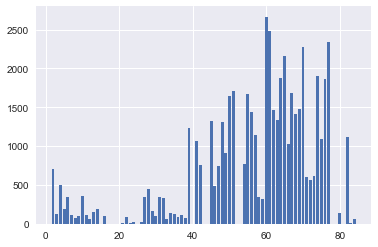

In [68]:
plt.bar(a_df_start_station['Start Terminal'], a_df_start_station['Trip ID'], align='center')#, alpha=0.5)
plt.show()

### 2.3.2 End Stations

We can see there is a significant gap between terminal 70 and other places again. To combine with the previous section, it could imply that the traffic flow which starts from 70 and heads to different places in the morning, now is comming back from different terminals in SF to terminal 70 again in the afternoon.  

In [69]:
a_df_end_station = afternoon.groupby('End Station').agg({'End Terminal': np.mean, 'Trip ID': pd.Series.nunique}).sort_values(['Trip ID'], ascending=False)
a_df_end_station['Percentage'] = a_df_end_station['Trip ID']/sum(a_df_end_station['Trip ID'])
a_df_end_station

,Trip ID,End Terminal,Percentage
End Station,,,
San Francisco Caltrain (Townsend at 4th),8560,70,0.165692
San Francisco Caltrain 2 (330 Townsend),3998,69,0.077388
Harry Bridges Plaza (Ferry Building),3154,50,0.061051
Steuart at Market,2361,74,0.045701
Temporary Transbay Terminal (Howard at Beale),2243,55,0.043417
Market at Sansome,1984,77,0.038403
Embarcadero at Sansome,1962,60,0.037978
2nd at Townsend,1769,61,0.034242
Powell Street BART,1632,39,0.031590


AS the graphs shows, the traffic flows go back to terminal 70

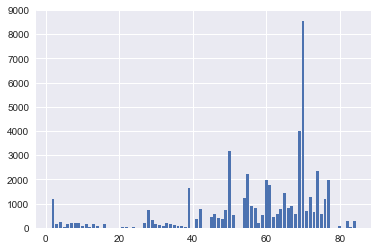

In [71]:
plt.bar(a_df_end_station['End Terminal'], a_df_end_station['Trip ID'], align='center')
plt.show()

## 2.5 Analyze the daily number of transportation

In [43]:
sf_scooter

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Scooter #,Subscriber Type,Zip Code,Duration_minutes,Duration_hours,Start Hour,End Hour
0,198776,177,2018-01-03 00:14:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2018-01-03 00:17:00,Market at Sansome,77,398,Subscriber,94105,2,0,0,0
1,198777,445,2018-01-03 00:16:00,San Francisco Caltrain (Townsend at 4th),70,2018-01-03 00:23:00,Embarcadero at Bryant,54,268,Subscriber,94105,7,0,0,0
2,198778,224,2018-01-03 00:21:00,Civic Center BART (7th at Market),72,2018-01-03 00:25:00,Golden Gate at Polk,59,380,Subscriber,94103,3,0,0,0
3,198779,179,2018-01-03 00:22:00,Powell Street BART,39,2018-01-03 00:25:00,Market at 4th,76,439,Subscriber,94107,2,0,0,0
4,198780,429,2018-01-03 00:42:00,Spear at Folsom,49,2018-01-03 00:49:00,Broadway St at Battery St,82,395,Subscriber,94105,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171787,432941,1091,2018-08-31 21:44:00,Embarcadero at Sansome,60,2018-08-31 22:02:00,Steuart at Market,74,598,Customer,94521,18,0,21,22
171788,432942,1041,2018-08-31 21:45:00,Embarcadero at Sansome,60,2018-08-31 22:02:00,Steuart at Market,74,603,Customer,94521,17,0,21,22
171789,432944,534,2018-08-31 22:06:00,Beale at Market,56,2018-08-31 22:15:00,Market at 4th,76,342,Customer,11231,8,0,22,22
171790,432945,468,2018-08-31 22:07:00,Beale at Market,56,2018-08-31 22:15:00,Market at 4th,76,509,Customer,11231,7,0,22,22


## 2.4 Conclusion 

According to the analysis above, there could be significantly large amount of passengers taking shared scooters travel from terminal 70 to other places in SF from 7 to 9 am, and then come back to terminal 70 in the afternoon from 4 to 6 pm. That could be very likely due to the commuting transportation that happens every day. Therefore, for potential further improvement, the escooter sharing company may consider to arrange more scooters near terminal 70 in the morning and other terminals which are the popular starting stations in the afternoon, to provide enough scooters for the passengers and optimize the customers' experience.  

# For the introduction of tableau visualizaiton 

I used the data provided in the email, integrating with the zipcode to GPS matching data and the polygon shapefile of San Francisco to plot the visualization. The developing work is done in tableau, and I have also attached the PDF screenshot of the dashboard in case you couldn't open it. The other two external data sources can be find below:

https://data.sfgov.org/Geographic-Locations-and-Boundaries/San-Francisco-ZIP-Codes/srq6-hmpi/data           
https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/
